In [1]:
import os
import tarfile
import urllib.request
import xml.etree.ElementTree as ET
import glob

# Download the .tar.gz file from the URL
url = "http://www.graphdrawing.org/download/rome-graphml.tgz"
filename = "rome-graphml.tgz"
if not os.path.exists(filename):
    print("Downloading file...")
    urllib.request.urlretrieve(url, filename)
    print("File downloaded.")

File downloaded.


In [8]:
# !tar -xvf rome-graphml.tgz|

In [31]:
# Iterate over all the files in the extracted directory
count = 0
edge_lists = []
graphs = []

for filename in glob.glob("rome/*.graphml"):
    # Open the file and read its contents
    with open(filename, "r") as f:
        content = f.read()

    # Parse the GraphML file using ElementTree
    root = ET.fromstring(content)

    # Find the <graph> element using the tag name only
    graph = root.findall("graph")[0]

    # Extract the list of nodes
    nodes = graph.findall("node")

    # Filter for graphs with less than 10 nodes
    
    if len(nodes) <= 11:
        count = count+1
        # Extract the list of edges
        edges = graph.findall("edge")
        node_dict = {node.attrib["id"]: i for i, node in enumerate(nodes)}
        edge_list = [(node_dict[edge.attrib["source"]], node_dict[edge.attrib["target"]]) for edge in edges]

        edge_lists.append(edge_list)
        graphs.append(graph)

        # Print the list of edges
        print(filename, edge_list)

print(count)

rome/grafo2931.11.graphml [(0, 6), (6, 1), (7, 4), (8, 3), (3, 9), (9, 4), (8, 2), (2, 5), (10, 6), (10, 7), (10, 4), (10, 2), (10, 3)]
rome/grafo2812.11.graphml [(0, 6), (6, 1), (1, 7), (7, 2), (7, 4), (1, 8), (8, 3), (3, 9), (9, 4), (3, 10), (10, 5)]
rome/grafo2953.11.graphml [(0, 5), (5, 1), (1, 6), (6, 2), (6, 3), (1, 7), (4, 8), (9, 4), (10, 3), (10, 4), (3, 4)]
rome/grafo2964.11.graphml [(3, 9), (9, 0), (0, 4), (4, 1), (1, 6), (6, 3), (1, 5), (5, 2), (1, 7), (8, 1), (10, 2), (4, 2)]
rome/grafo376.10.graphml [(0, 6), (6, 1), (1, 7), (7, 2), (7, 3), (3, 8), (8, 4), (3, 9), (9, 5)]
rome/grafo857.11.graphml [(7, 1), (1, 6), (6, 2), (2, 5), (5, 3), (4, 8), (8, 3), (5, 6), (7, 9), (9, 0), (10, 5)]
rome/grafo2129.11.graphml [(0, 1), (2, 3), (0, 3), (4, 5), (5, 6), (1, 6), (4, 1), (4, 3), (1, 7), (7, 8), (8, 1), (2, 8), (4, 8), (1, 9), (9, 2), (10, 6), (10, 4)]
rome/grafo267.11.graphml [(1, 6), (2, 6), (6, 0), (5, 7), (7, 0), (7, 3), (3, 8), (8, 0), (8, 9), (9, 4), (10, 4)]
rome/grafo532

In [52]:
from collections import deque

def bfs(graph, start_node):
    visited = {start_node}
    queue = deque([(start_node, 0)])
    node_ranks = {}

    while queue:
        current_node, depth = queue.popleft()

        if depth not in node_ranks:
            node_ranks[depth] = [current_node]
        else:
            node_ranks[depth].append(current_node)

        for edge in graph:
            source, target = edge
            if source == current_node and target not in visited:
                visited.add(target)
                queue.append((target, depth + 1))
            elif target == current_node and source not in visited:
                visited.add(source)
                queue.append((source, depth + 1))

    return node_ranks

print(edge_lists[0])
print(bfs(edge_lists[0], 0))

[(0, 6), (6, 1), (7, 4), (8, 3), (3, 9), (9, 4), (8, 2), (2, 5), (10, 6), (10, 7), (10, 4), (10, 2), (10, 3)]
{0: [0], 1: [6], 2: [1, 10], 3: [7, 4, 2, 3], 4: [9, 8, 5]}


In [90]:
count = 0
filenames_timeout = []
malformed_answers = []
infinity_ranks = []

correctness = []

for filename in glob.glob("rome/*.graphml"):
    # Open the file and read its contents
    with open(filename, "r") as f:
        content = f.read()

    # Parse the GraphML file using ElementTree
    root = ET.fromstring(content)

    # Find the <graph> element using the tag name only
    graph = root.findall("graph")[0]

    # Extract the list of nodes
    nodes = graph.findall("node")

    # Filter for graphs with less than 10 nodes
    
    if len(nodes) <= 11:
        count = count+1
        # Extract the list of edges
        edges = graph.findall("edge")
        node_dict = {node.attrib["id"]: i for i, node in enumerate(nodes)}
        edge_list = [(node_dict[edge.attrib["source"]], node_dict[edge.attrib["target"]]) for edge in edges]

        with open("answers/rank_prompts/" + filename.replace("rome/", "").replace(".graphml", "") + ".txt", "r") as f:
            content = f.read().replace(".", "")
            newranks = {}

            if "Too many requests in 1 hour" in content:
                filenames_timeout.append(filename)
                continue
            if "infinity" in content or "INF" in content or "∞" in content or "inf" in content or "unreachable" in content:
                infinity_ranks.append(filename)
                continue
            
            try:
                if "," in content:
                    for line in content.split(","):
                        l = line.split("-")
                        if int(l[1]) not in newranks:
                            newranks[int(l[1])] = [int(l[0])]
                        else:
                            newranks[int(l[1])].append(int(l[0]))
                else:
                    for line in content.splitlines():
                        l = line.split("-")
                        if int(l[1]) not in newranks:
                            newranks[int(l[1])] = [int(l[0])]
                        else:
                            newranks[int(l[1])].append(int(l[0]))

                trueranks = bfs(edge_list, 0)
                maxnodes = len(nodes)
                correct = 0

                for rank in newranks:
                    for node in newranks[rank]:
                        if rank not in trueranks:
                            continue
                        if node in trueranks[rank]:
                            correct += 1

                print(correct)
                print(trueranks)
                print(newranks)

                correctness.append(correct/maxnodes)


            except Exception as e:
                print(e)
                print(filename)
                print(content)
                print(edge_list)
                print(bfs(edge_list, 0))

                if "list index out of range" in str(e):
                    malformed_answers.append(filename)
                    continue

print(count)
print(len(filenames_timeout), len(malformed_answers), len(infinity_ranks))
print(correctness)

2
{0: [0], 1: [6], 2: [1], 3: [7, 8], 4: [2, 4, 3], 5: [9, 10], 6: [5]}
{0: [0], 1: [6, 1], 2: [7, 4, 8], 3: [2, 3], 4: [9, 10], 5: [5]}
2
{0: [0], 1: [5], 2: [1], 3: [6, 7], 4: [2, 3], 5: [10, 4], 6: [8, 9]}
{0: [0], 1: [5, 1], 2: [4, 6, 7], 3: [9, 10, 2, 3, 8]}
3
{0: [0], 1: [6], 2: [1], 3: [7], 4: [2, 3], 5: [8, 9], 6: [4, 5]}
{0: [0], 1: [6], 2: [1, 7], 3: [2, 3], 4: [8, 9], 5: [4, 5]}
1
{0: [0], 1: [9], 2: [7], 3: [1], 4: [6], 5: [2, 5], 6: [3, 10], 7: [8], 8: [4]}
{0: [0], 1: [1, 5, 7], 2: [2, 6, 9], 3: [3], 4: [4, 8, 10]}
8
{0: [0], 1: [1, 3], 2: [6, 4, 7, 8, 9, 2], 3: [5, 10]}
{0: [0], 1: [1, 3, 4], 2: [2, 5, 6, 7, 8, 9, 10]}
11
{0: [0], 1: [6, 7, 8], 2: [1, 2, 5, 3, 9], 3: [4], 4: [10]}
{0: [0], 2: [1, 2, 3, 5, 9], 3: [4], 1: [6, 7, 8], 4: [10]}
8
{0: [0], 1: [7, 6, 10], 2: [1, 2, 9, 4], 3: [5, 8], 4: [3]}
{0: [0], 1: [7, 6], 2: [1, 10, 2, 9], 3: [5, 4], 4: [8, 3]}
3
{0: [0], 1: [6], 2: [1], 3: [7], 4: [2, 3], 5: [8, 9], 6: [4, 5]}
{0: [0], 1: [6], 2: [1, 7], 3: [2, 3], 4: [8,

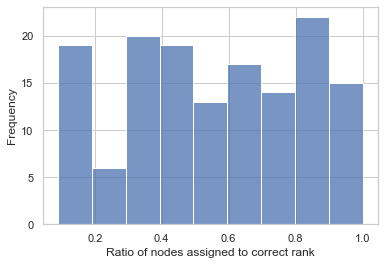

In [102]:
# draw scatterplot
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(correctness, stat='count')

# Set the labels for the x and y axes
plt.xlabel('Ratio of nodes assigned to correct rank')
plt.ylabel('Frequency')

# Show the plot
plt.show()

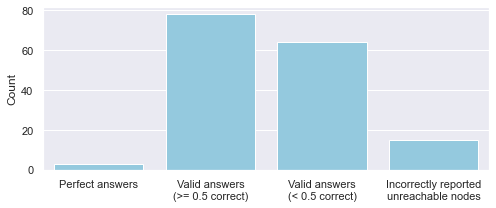

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Generate some sample data as a dictionary
data = {}
data["Perfect answers"] = len(list(filter(lambda x: x == 1, correctness)))
data["Valid answers\n(>= 0.5 correct)"] = len(list(filter(lambda x: x >= 0.5 and x != 1, correctness)))
data["Valid answers\n(< 0.5 correct)"] = len(list(filter(lambda x: x < 0.5, correctness)))
data["Incorrectly reported\nunreachable nodes"] = len(infinity_ranks)

# Convert the dictionary to a Pandas DataFrame for plotting
df = pd.DataFrame.from_dict(data, orient='index', columns=['Value'])

sns.set(rc={'figure.figsize':(8,3)})

# Use Seaborn to create a bar chart
sns.barplot(x=df.index, y='Value', data=df, color='skyblue')

# Set the labels for the x and y axes
# plt.xSabel('Label')
plt.ylabel('Count')

# Show the plot
plt.show()


In [47]:
#create transpose prompts
for i, graph in enumerate(edge_lists):
    prompt = """We want to reduce crossings on a graph drawing.
This is the list of edges. Every edge has [<source_id>, <target_id>]:
edges = """

    prompt += str(graph) + "\n\n"
    prompt += """This is a dictionary that contains the ranks of the nodes: \nranks = """
    prompt += str(bfs(edge_lists[10], 0)) + "\n"

    prompt += """it is defined so that ranks[<rank_number>] is equal to the list of nodes contained in that rank.

I want to order the nodes in the ranks so that there are few crossings in the graph. 
- visit every rank once, starting from rank 0
- try different transpositions of the nodes in that rank
- count the crossings for every transposition. There is a crossing between two edges e1 and e2 if the source of e1 comes before the source of e2, and the target of e1 comes after the target of e2 in the node orderings.
- record the transposition that produces the least amount of crossings, and sort the nodes accordingly.

write no code and no explanation.
return the ranks dictionary with the nodes ordered, in a code block."""

    with open("queries/transpose_prompts/" + glob.glob("rome/*.graphml")[i].split("/")[-1].replace(".graphml", "") + ".txt", "w+") as f:
        f.write(prompt)


In [30]:
from itertools import permutations

def order_nodes_within_rank(graph, node_rank):
    ordered_nodes = []
    
    for rank in range(len(node_rank)):
        rank_nodes = node_rank[rank]
        
        if len(rank_nodes) == 1:
            ordered_nodes.append(rank_nodes[0])
        else:
            min_crossings = float('inf')
            min_order = rank_nodes
            for order in permutations(rank_nodes):
                crossings = count_edge_crossings(graph, order)
                if crossings < min_crossings:
                    min_crossings = crossings
                    min_order = order
            ordered_nodes.extend(min_order)
    return ordered_nodes

def count_edge_crossings(graph, node_order):
    crossings = 0
    for i in range(len(node_order)):
        for j in range(i + 1, len(node_order)):
            a, b = node_order[i], node_order[j]
            a_outgoing = [v for u, v in graph if u == a and v in node_order[i+1:j]]
            b_incoming = [u for u, v in graph if v == b and u in node_order[i:j-1]]
            crossings += len(a_outgoing) * len(b_incoming)
    return crossings


# print(order_nodes_within_rank(edge_lists[0], bfs(edge_lists[0], 0)))
ordered_nodes = order_nodes_within_rank(edge_lists[0], bfs(edge_lists[0], 0))

for rank, nodes in bfs(edge_lists[0], 0).items():
    ordered_nodes_in_rank = [node for node in ordered_nodes if node in nodes]
    print(f"Rank {rank}: {ordered_nodes_in_rank}")

0 [0]
1 [6]
2 [1]
3 [7]
4 [2, 3]
5 [8, 9]
6 [4, 5]
Rank 0: [0]
Rank 1: [6]
Rank 2: [1]
Rank 3: [7]
Rank 4: [2, 3]
Rank 5: [8, 9]
Rank 6: [4, 5]
